In [8]:
"""This code is written by Shashank Shekhar as a project done on Semantic Segmentation."""
import os  # To load the directory for reading the images and mask path
import random # To generate random number
import numpy as np # To create numpy array and perform some operation on them
import cv2       # To read the images from disks
import matplotlib.pyplot as plt # To read the images and masks from disks
import tensorflow as tf # To perform neural network operation

In [7]:
# Seeding
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed

In [29]:
# Data Generator
class DataGen(tf.keras.utils.Sequence):
    def __init__(self, ids, path, batch_size=8, image_size=128):
        self.ids = ids # Name of directory which contain both images and masks directory
        self.path = path # a path on your machine where data directory is located
        self.batch_size = batch_size
        self.image_size = image_size
    def __load__(self, id_name): # To load every single images and mask
        # Path
        image_path = os.path.join(self.path, id_name, 'images', id_name) + '.png'
        mask_path = os.path.join(self.path, id_name, 'masks/')
        all_masks = os.listdir(mask_path)
        # Reading image
        # Since out image is in GrayScale form but we need image in 3 channel form
        image = cv2.imread(image_path, 1) # Here 1 specify that image is loaded in form of BGR form
        image = cv2.resize(image, (self.image_size,self.image_size)) # Resize the from 256 to 128
        mask = np.zeros((self.image_size, self.image_size, 1)) # Create a image filled with zero for display the mask
        # Reading Masks
        for name in all_masks:
            _mask_path = mask_path + name
            _mask_image = cv2.imread(_mask_path, -1)
            _mask_image = cv2.resize(_mask_image, (self.image_size, self.image_size))
            _mask_image = np.expand_dims(_mask_image, axis=-1)
            # Compare two arrays and returns a new array containing the element-wise maxima.
            mask = np.maximum(mask, _mask_image)
        # Normalize the both image and mask.    
        image = image/255.0
        mask = mask/255.0
        return image, mask

    def __getitem__(self, index):
        files_batch = self.ids[index*self.batch_size:(index+1)*self.batch_size] # Take the batch of directories
        image = []
        mask = []
        # pass each directory name to __load__() method, where we extract both image and masks and perform operations.
        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask)
        image = np.array(image)
        mask = np.array(mask)
        return image, mask
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

In [22]:
# Hyperparameters
image_size = 128
train_path = '/home/shashank/Documents/kaggle_data/nuclei-data-bowl-2018/stage1_train'
epochs = 5
batch_size = 8
# Training Ids
train_ids = next(os.walk(train_path))[1]
#print(train_ids)
# Validation data size
val_data_size = 10
valid_ids = train_ids[:val_data_size]
train_ids = train_ids[val_data_size:]

gen = DataGen(train_ids, train_path, batch_size=batch_size, image_size=image_size)
x, y = gen.__getitem__(0)
print(x.shape, y.shape)

(8, 128, 128, 3) (8, 128, 128, 1)


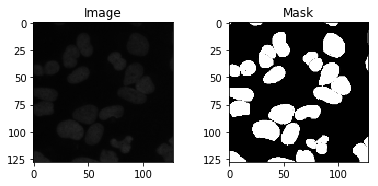

In [47]:
r = random.randint(0, len(x)-1)
fig = plt.figure()
fig.subplots_adjust(hspace=0.4,wspace=0.4)
ax = fig.add_subplot(1,2,1)
ax.set_title('Image')
ax.imshow(x[r])
ax = fig.add_subplot(1,2,2)
ax.set_title('Mask')
ax.imshow(np.reshape(y[r], (image_size, image_size)),cmap='gray')
plt.show()

In [26]:
# Different Convolutional Blocks
def down_block(x, filters, kernel_size=(3,3), padding='same', strides=1):
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation='relu')(x)
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation='relu')(c)
    p = tf.keras.layers.MaxPool2D((2,2),(2,2))(c)
    return c,p

def up_block(x, skip, filters, kernel_size=(3,3), padding='same', strides=1):
    us = tf.keras.layers.UpSampling2D((2,2))(x)
    concat = tf.keras.layers.Concatenate()([us,skip])
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation='relu')(concat)
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation='relu')(concat)
    return c

def bottleneck(x, filters, kernel_size=(3,3), padding='same', strides=1):
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation='relu')(x)
    c = tf.keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation='relu')(c)
    return c

# UNet Model
def UNet():
    f = [16,32,64,128,256]
    inputs = tf.keras.layers.Input((image_size,image_size,3))
    p0 = inputs
    c1, p1 = down_block(p0, f[0]) # 128 -> 64
    c2, p2 = down_block(p1, f[1]) # 64 -> 32
    c3, p3 = down_block(p2, f[2]) # 32 -> 16
    c4, p4 = down_block(p3, f[3]) # 16 -> 8

    bn = bottleneck(p4, f[4])

    u1 = up_block(bn, c4, f[3]) # 8 -> 16
    u2 = up_block(u1, c3, f[2]) # 16 -> 32
    u3 = up_block(u2, c2, f[1]) # 32 -> 64
    u4 = up_block(u3, c1, f[0]) # 64 -> 128

    outputs = tf.keras.layers.Conv2D(1, (1,1), padding='same', activation='sigmoid')(u4)
    model = tf.keras.models.Model(inputs, outputs)
    return model

In [27]:
model = UNet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 128, 128, 16) 448         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 128, 128, 16) 2320        conv2d_19[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_4 (MaxPooling2D)  (None, 64, 64, 16)   0           conv2d_20[0][0]                  
__________________________________________________________________________________________________
conv2d_21 

In [30]:
train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size)
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size)

train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size

model.fit_generator(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, epochs=epochs)

Epoch 1/5
82/82 [==============================] - 102s 1s/step - loss: 0.3989 - acc: 0.8461 - val_loss: 0.2390 - val_acc: 0.8548
Epoch 2/5
82/82 [==============================] - 139s 2s/step - loss: 0.2007 - acc: 0.9006 - val_loss: 0.1814 - val_acc: 0.9158
Epoch 3/5
82/82 [==============================] - 87s 1s/step - loss: 0.1242 - acc: 0.9372 - val_loss: 0.0990 - val_acc: 0.9461
Epoch 4/5
82/82 [==============================] - 79s 961ms/step - loss: 0.1062 - acc: 0.9434 - val_loss: 0.0995 - val_acc: 0.9473
Epoch 5/5
82/82 [==============================] - 78s 952ms/step - loss: 0.0898 - acc: 0.9497 - val_loss: 0.1016 - val_acc: 0.9456


(8, 128, 128, 3)
(8, 128, 128, 1)


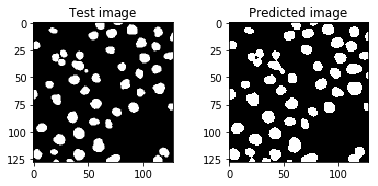

In [56]:
# Testing the model
# Dataset for prediction
x, y = valid_gen.__getitem__(0)
print(x.shape)
result = model.predict(x)
print(result.shape)
result = result > 0.5

fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1,2,1)
ax.set_title('Test image')
ax.imshow(np.reshape(y[0]*255, (image_size, image_size)), cmap='gray')
ax = fig.add_subplot(1,2,2)
ax.set_title('Predicted image')
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap='gray')
plt.show()